# 项目作业：单因子模型

## 选取2~4个基本面因子进行单因子有效性检验，填写完整各个指标

In [1]:
import numpy as np
import pandas as pd
from alphalens import utils, plotting, tears, performance

### 第一个因子为PE
### 数据准备

In [2]:
# 时间区间
tradingDates = get_trading_dates('20190101', '20191231')
startDate = tradingDates[0]
endDate = tradingDates[-1]

# 股票池
stockList = index_components('000300.XSHG')

# 每日行情
price = get_price(stockList,
                  start_date=startDate,
                  end_date=endDate,
                  fields='close')

In [3]:
# 创建沪深300的PE查询
qPE = query(fundamentals.eod_derivative_indicator.pe_ratio).filter(
    fundamentals.eod_derivative_indicator.stockcode.in_(stockList))

In [4]:
# 获取并拼接每个交易日的PE数据
factor_PE_df = pd.DataFrame()
for date in tradingDates:
    daily_data = get_fundamentals(qPE, date, expect_df=True)
    daily_data = daily_data.reset_index()
    daily_data['date'] = date
    daily_data = daily_data.set_index(['date', 'order_book_id'])
    factor_PE_df = pd.concat([factor_PE_df, daily_data])

In [5]:
factor_PE_df.head(30)

pe_ratio
date       order_book_id          
2019-01-02 000001.XSHE      6.3581
           000002.XSHE      7.8121
           000063.XSHE    -11.7429
           000069.XSHE      4.6315
           000100.XSHE      9.8061
           000157.XSHE     13.4146
           000166.XSHE     21.8849
           000333.XSHE     12.0016
           000338.XSHE      6.9834
           000413.XSHE     11.8387
           000415.XSHE      9.5780
           000423.XSHE     12.4068
           000425.XSHE     12.3303
           000538.XSHE     21.4404
           000568.XSHE     16.6409
           000596.XSHE     15.6852
           000625.XSHE     46.7052
           000627.XSHE     20.8945
           000629.XSHE      8.3113
           000630.XSHE     28.9612
           000651.XSHE      8.2191
           000656.XSHE      8.3684
           000661.XSHE     28.7494
           000671.XSHE      6.9115
           000703.XSHE     16.1397
           000709.XSHE      8.3454
           000723.XSHE      7.2621
           000725.XSHE     26.1358
           000728.XSHE     35.1921
           000768.XSHE     65.7384

### 数据预处理

In [6]:
# 去极值化函数
def winsorize_series(series):
    qt = series.quantile([0.02, 0.98])
    if isinstance(qt, pd.Series) and len(qt) == 2:
        series[series < qt.iloc[0]] = qt.iloc[0]
        series[series > qt.iloc[1]] = qt.iloc[1]
    return series


# 标准化函数
def standardize_series(series):
    std = series.std()
    mean = series.mean()
    return (series - mean) / std

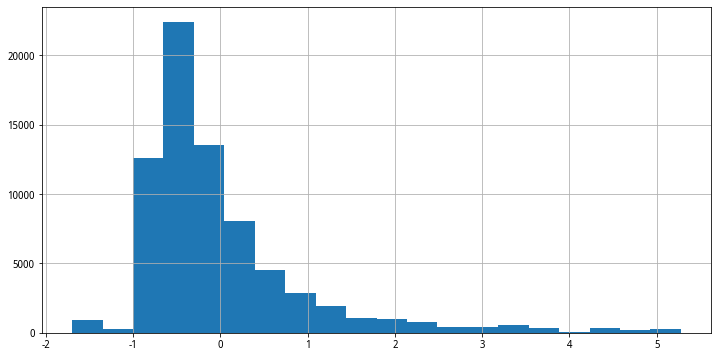

In [7]:
# 把dataframe转换成series
factor_PE_sr = factor_PE_df['pe_ratio']
# 去极值化
factor_PE_sr = factor_PE_sr.groupby(level='date').apply(winsorize_series)
# 标准化
factor_PE_sr = factor_PE_sr.groupby(level='date').apply(standardize_series)

factor_PE_df['pe_ratio'] = factor_PE_sr
factor_PE_sr.hist(figsize=(12, 6), bins=20)

### 使用alphalens进行分析

In [8]:
factor_PE_analysis = utils.get_clean_factor_and_forward_returns(
    factor_PE_sr, price)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [9]:
# 减少数字格式错误
factor_PE_analysis['factor'] = np.float128(factor_PE_analysis['factor'])

In [10]:
factor_PE_analysis

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362 -0.670288   
           000002.XSHE  0.007115  0.059832  0.063601 -0.622424   
           000063.XSHE -0.039877  0.018405  0.038344 -0.809417   
           000069.XSHE  0.001678  0.045231  0.033499 -0.727127   
           000100.XSHE  0.007982  0.123527  0.067739 -0.556783   
           000157.XSHE  0.014401  0.048995  0.054755 -0.437994   
           000166.XSHE  0.022286  0.089120  0.084167 -0.159159   
           000333.XSHE -0.006586  0.070251  0.130624 -0.484509   
           000338.XSHE -0.009262  0.026443  0.074069 -0.649704   
           000413.XSHE  0.004492  0.082781  0.089496 -0.489872   
           000415.XSHE  0.008499  0.067989  0.082153 -0.564292   
           000423.XSHE -0.012643  0.026296  0.025537 -0.471170   
           000425.XSHE -0.006200  0.018664  0.018664 -0.473689   
           000538.XSHE -0.026971  0.033087  0.070485 -0.173792   
           000568.XSHE -0.037122 -0.002777  0.038132 -0.331787   
           000596.XSHE -0.037122  0.021212  0.100757 -0.363248   
           000625.XSHE  0.012082  0.125379  0.126893  0.657905   
           000627.XSHE -0.008897  0.008915 -0.005335 -0.191762   
           000629.XSHE  0.040134  0.043478  0.113712 -0.605991   
           000630.XSHE  0.005140  0.035931  0.035931  0.073787   
           000651.XSHE  0.003354  0.047765  0.098044 -0.609026   
           000656.XSHE  0.011495 -0.027913 -0.021339 -0.604111   
           000661.XSHE -0.012816  0.051323  0.087243  0.066815   
           000671.XSHE  0.005838  0.042728  0.031071 -0.652071   
           000703.XSHE -0.006084  0.099131  0.076524 -0.348286   
           000709.XSHE  0.003520  0.031608  0.066664 -0.604868   
           000723.XSHE -0.003135  0.031348  0.300940 -0.640530   
           000725.XSHE  0.000000  0.042613  0.034872 -0.019223   
           000728.XSHE  0.027101  0.106981  0.099846  0.278903   
           000768.XSHE  0.034718  0.058117  0.064908  1.284462   
...                          ...       ...       ...       ...   
2019-12-17 601838.XSHG -0.003378 -0.007883  0.021396 -0.851512   
           601857.XSHG -0.005128 -0.020513 -0.003419 -0.154406   
           601877.XSHG  0.001139 -0.015572  0.017850 -0.518906   
           601878.XSHG  0.099589  0.097536  0.142710  0.237573   
           601881.XSHG  0.005263 -0.003509  0.018421 -0.225914   
           601888.XSHG -0.005840  0.018689  0.039014  0.227845   
           601898.XSHG -0.002045  0.000000  0.026585 -0.611789   
           601899.XSHG -0.005013  0.032581  0.150376 -0.107574   
           601901.XSHG  0.000000  0.113764  0.217697  0.557544   
           601919.XSHG -0.011605 -0.011605  0.019342 -0.160988   
           601933.XSHG -0.010417  0.031250 -0.018229  0.237801   
           601939.XSHG  0.001383 -0.005533  0.000000 -0.826596   
           601985.XSHG  0.000000 -0.013619 -0.027237 -0.452731   
           601988.XSHG -0.002717 -0.002717  0.002717 -0.861653   
           601989.XSHG -0.005607 -0.024299 -0.020561  3.558489   
           601992.XSHG -0.002967  0.017804  0.106825 -0.738004   
           601997.XSHG -0.007239 -0.019648 -0.011375 -0.874541   
           601998.XSHG  0.001608 -0.014469 -0.008039 -0.845013   
           603019.XSHG -0.006029 -0.057276 -0.052343  1.238490   
           603156.XSHG -0.001414  0.006365  0.026521 -0.693184   
           603160.XSHG -0.024903 -0.113013 -0.065924  0.607053   
           603259.XSHG -0.032311 -0.058793 -0.058078  1.647752   
           603260.XSHG -0.008742 -0.005380 -0.009079 -0.369825   
           603288.XSHG -0.009303 -0.013954  0.000093  0.967944   
           603501.XSHG -0.015298 -0.000989 -0.054402  3.558489   
           603799.XSHG -0.006534  0.098631  0.225576 -1.433550   
           603833.XSHG  0.058196  0.052481  0.114392 -0.171953   
           603899.XSHG -0.006257 -0.032325  0.016475  0.525647   
    

In [11]:
# 计算因子IC
PE_IC = performance.factor_information_coefficient(factor_PE_analysis)

In [12]:
PE_IC

,1D,5D,10D
date,,,
2019-01-02,0.087844,0.149113,0.145319
2019-01-03,0.090816,0.177844,0.086643
2019-01-04,0.187607,0.020216,-0.074934
2019-01-07,0.020762,-0.164285,-0.184967
2019-01-08,-0.180570,-0.053397,-0.230291
2019-01-09,-0.050528,-0.022781,-0.175340
2019-01-10,-0.007709,-0.123156,-0.088409
2019-01-11,-0.097553,-0.174128,-0.202586
2019-01-14,0.133318,-0.133039,-0.161829


In [13]:
# 计算IC均值、标准差，IR
PE_IC_mean = PE_IC['1D'].mean()
PE_IC_std = PE_IC['1D'].std()
PE_IR = PE_IC_mean / PE_IC_std
print(PE_IC_mean, PE_IC_std, PE_IR)

-0.0024993560052110966 0.16978512861170186 -0.014720700367857996


In [14]:
# 计算IC>0.02的频率
PE_freq = PE_IC[PE_IC['1D'] > 0.02]['1D'].count() / PE_IC['1D'].count()
PE_freq

0.4700854700854701

In [15]:
# 计算因子收益率
factor_PE_return = performance.factor_returns(factor_PE_analysis)
factor_PE_mean_return = factor_PE_return['1D'].mean()
factor_PE_mean_return

0.0003949246913419875

### 第二个因子为市值
### 数据准备

In [16]:
# 创建沪深300的市值查询
qMC = query(fundamentals.eod_derivative_indicator.market_cap).filter(
    fundamentals.eod_derivative_indicator.stockcode.in_(stockList))

In [17]:
# 获取并拼接每个交易日的市场数据
factor_MC_df = pd.DataFrame()
for date in tradingDates:
    daily_data = get_fundamentals(qMC, date, expect_df=True)
    daily_data = daily_data.reset_index()
    daily_data['date'] = date
    daily_data = daily_data.set_index(['date', 'order_book_id'])
    factor_MC_df = pd.concat([factor_MC_df, daily_data])

### 数据预处理

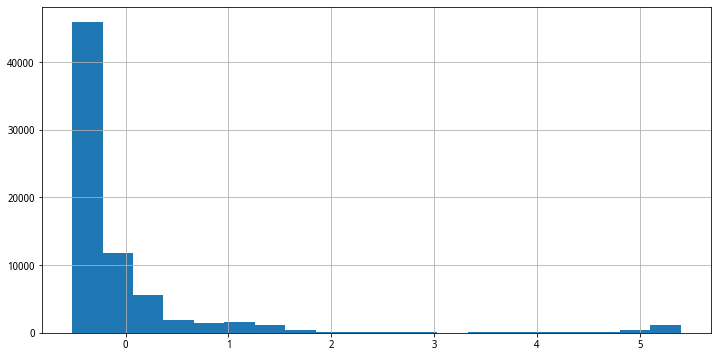

In [18]:
# 把factor_MC_df的格式进行转换
factor_MC_sr = factor_MC_df['market_cap']
# 去极值化、标准化
factor_MC_sr = factor_MC_sr.groupby(level='date').apply(winsorize_series)
factor_MC_sr = factor_MC_sr.groupby(level='date').apply(standardize_series)

factor_MC_df['market_cap'] = factor_MC_sr
factor_MC_sr.hist(figsize=(12, 6), bins=20)

### 使用alphalens进行分析

In [19]:
factor_MC_analysis = utils.get_clean_factor_and_forward_returns(
    factor_MC_sr, price)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [20]:
factor_MC_analysis['factor'] = np.float128(factor_MC_analysis)

In [21]:
factor_MC_analysis

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362  0.009790   
           000002.XSHE  0.007115  0.059832  0.063601  0.007115   
           000063.XSHE -0.039877  0.018405  0.038344 -0.039877   
           000069.XSHE  0.001678  0.045231  0.033499  0.001678   
           000100.XSHE  0.007982  0.123527  0.067739  0.007982   
           000157.XSHE  0.014401  0.048995  0.054755  0.014401   
           000166.XSHE  0.022286  0.089120  0.084167  0.022286   
           000333.XSHE -0.006586  0.070251  0.130624 -0.006586   
           000338.XSHE -0.009262  0.026443  0.074069 -0.009262   
           000413.XSHE  0.004492  0.082781  0.089496  0.004492   
           000415.XSHE  0.008499  0.067989  0.082153  0.008499   
           000423.XSHE -0.012643  0.026296  0.025537 -0.012643   
           000425.XSHE -0.006200  0.018664  0.018664 -0.006200   
           000538.XSHE -0.026971  0.033087  0.070485 -0.026971   
           000568.XSHE -0.037122 -0.002777  0.038132 -0.037122   
           000596.XSHE -0.037122  0.021212  0.100757 -0.037122   
           000625.XSHE  0.012082  0.125379  0.126893  0.012082   
           000627.XSHE -0.008897  0.008915 -0.005335 -0.008897   
           000629.XSHE  0.040134  0.043478  0.113712  0.040134   
           000630.XSHE  0.005140  0.035931  0.035931  0.005140   
           000651.XSHE  0.003354  0.047765  0.098044  0.003354   
           000656.XSHE  0.011495 -0.027913 -0.021339  0.011495   
           000661.XSHE -0.012816  0.051323  0.087243 -0.012816   
           000671.XSHE  0.005838  0.042728  0.031071  0.005838   
           000703.XSHE -0.006084  0.099131  0.076524 -0.006084   
           000709.XSHE  0.003520  0.031608  0.066664  0.003520   
           000723.XSHE -0.003135  0.031348  0.300940 -0.003135   
           000725.XSHE  0.000000  0.042613  0.034872  0.000000   
           000728.XSHE  0.027101  0.106981  0.099846  0.027101   
           000768.XSHE  0.034718  0.058117  0.064908  0.034718   
...                          ...       ...       ...       ...   
2019-12-17 601838.XSHG -0.003378 -0.007883  0.021396 -0.003378   
           601857.XSHG -0.005128 -0.020513 -0.003419 -0.005128   
           601877.XSHG  0.001139 -0.015572  0.017850  0.001139   
           601878.XSHG  0.099589  0.097536  0.142710  0.099589   
           601881.XSHG  0.005263 -0.003509  0.018421  0.005263   
           601888.XSHG -0.005840  0.018689  0.039014 -0.005840   
           601898.XSHG -0.002045  0.000000  0.026585 -0.002045   
           601899.XSHG -0.005013  0.032581  0.150376 -0.005013   
           601901.XSHG  0.000000  0.113764  0.217697  0.000000   
           601919.XSHG -0.011605 -0.011605  0.019342 -0.011605   
           601933.XSHG -0.010417  0.031250 -0.018229 -0.010417   
           601939.XSHG  0.001383 -0.005533  0.000000  0.001383   
           601985.XSHG  0.000000 -0.013619 -0.027237  0.000000   
           601988.XSHG -0.002717 -0.002717  0.002717 -0.002717   
           601989.XSHG -0.005607 -0.024299 -0.020561 -0.005607   
           601992.XSHG -0.002967  0.017804  0.106825 -0.002967   
           601997.XSHG -0.007239 -0.019648 -0.011375 -0.007239   
           601998.XSHG  0.001608 -0.014469 -0.008039  0.001608   
           603019.XSHG -0.006029 -0.057276 -0.052343 -0.006029   
           603156.XSHG -0.001414  0.006365  0.026521 -0.001414   
           603160.XSHG -0.024903 -0.113013 -0.065924 -0.024903   
           603259.XSHG -0.032311 -0.058793 -0.058078 -0.032311   
           603260.XSHG -0.008742 -0.005380 -0.009079 -0.008742   
           603288.XSHG -0.009303 -0.013954  0.000093 -0.009303   
           603501.XSHG -0.015298 -0.000989 -0.054402 -0.015298   
           603799.XSHG -0.006534  0.098631  0.225576 -0.006534   
           603833.XSHG  0.058196  0.052481  0.114392  0.058196   
           603899.XSHG -0.006257 -0.032325  0.016475 -0.006257   
    

In [22]:
# 计算因子IC
MC_IC = performance.factor_information_coefficient(factor_MC_analysis)
MC_IC

,1D,5D,10D
date,,,
2019-01-02,1.0,0.545160,0.296790
2019-01-03,1.0,0.437517,0.376677
2019-01-04,1.0,0.617392,0.324937
2019-01-07,1.0,0.318565,0.211570
2019-01-08,1.0,0.520815,0.510667
2019-01-09,1.0,0.468214,0.402070
2019-01-10,1.0,0.371480,0.193102
2019-01-11,1.0,0.211748,0.093402
2019-01-14,1.0,0.459769,0.374113


In [23]:
# 创建函数，计算IC均值、标准差、IR
def mean_std_ir(series):
    sr_mean = series.mean()
    sr_std = series.std()
    sr_IR = sr_mean / sr_std
    return sr_mean, sr_std, sr_IR


MC_IC_mean, MC_IC_std, MC_IR = mean_std_ir(MC_IC['1D'])
print(MC_IC_mean, MC_IC_std, MC_IR)

1.0 6.900070435564634e-17 1.4492605681903736e+16


In [24]:
# 计算IC>0.02的频率
MC_freq = MC_IC[MC_IC['1D'] > 0.02]['1D'].count() / MC_IC['1D'].count()
MC_freq

1.0

In [25]:
# 计算因子收益率
factor_MC_return = performance.factor_returns(factor_MC_analysis)
factor_MC_mean_return = factor_MC_return['1D'].mean()
factor_MC_mean_return

0.026977642598970387

### 第三个因子为EPS
### 数据准备

In [26]:
# 创建EPS查询
qEPS = query(fundamentals.income_statement.basic_earnings_per_share).filter(
    fundamentals.income_statement.stockcode.in_(stockList))

In [27]:
# 获取并拼接市场数据
factor_EPS_df = pd.DataFrame()
for date in tradingDates:
    daily_data = get_fundamentals(qEPS, date, expect_df=True)
    daily_data = daily_data.reset_index()
    daily_data['date'] = date
    daily_data = daily_data.set_index(['date', 'order_book_id'])
    factor_EPS_df = pd.concat([factor_EPS_df, daily_data])

### 数据预处理

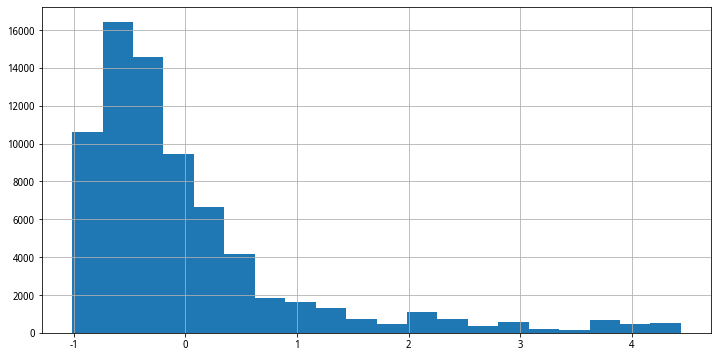

In [28]:
factor_EPS_sr = factor_EPS_df['basic_earnings_per_share']
# 去极值化、标准化
factor_EPS_sr = factor_EPS_sr.groupby(level='date').apply(winsorize_series)
factor_EPS_sr = factor_EPS_sr.groupby(level='date').apply(standardize_series)

factor_EPS_df['basic_earnings_per_share'] = factor_EPS_sr
factor_EPS_sr.hist(figsize=(12, 6), bins=20)

### 使用alphalens进行分析

In [29]:
factor_EPS_analysis = utils.get_clean_factor_and_forward_returns(
    factor_EPS_sr, price)

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [30]:
factor_EPS_analysis['factor'] = np.float128(factor_EPS_analysis['factor'])

In [31]:
factor_EPS_analysis

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362  0.541576   
           000002.XSHE  0.007115  0.059832  0.063601  0.713510   
           000063.XSHE -0.039877  0.018405  0.038344 -1.004197   
           000069.XSHE  0.001678  0.045231  0.033499 -0.161730   
           000100.XSHE  0.007982  0.123527  0.067739 -0.752399   
           000157.XSHE  0.014401  0.048995  0.054755 -0.771623   
           000166.XSHE  0.022286  0.089120  0.084167 -0.798699   
           000333.XSHE -0.006586  0.070251  0.130624  2.680601   
           000338.XSHE -0.009262  0.026443  0.074069  0.013589   
           000413.XSHE  0.004492  0.082781  0.089496 -0.690394   
           000415.XSHE  0.008499  0.067989  0.082153 -0.468639   
           000423.XSHE -0.012643  0.026296  0.025537  1.534057   
           000425.XSHE -0.006200  0.018664  0.018664 -0.737778   
           000538.XSHE -0.026971  0.033087  0.070485  3.289817   
           000568.XSHE -0.037122 -0.002777  0.038132  1.540690   
           000596.XSHE -0.037122  0.021212  0.100757  2.369224   
           000625.XSHE  0.012082  0.125379  0.126893 -0.676856   
           000627.XSHE -0.008897  0.008915 -0.005335 -0.731008   
           000629.XSHE  0.040134  0.043478  0.113712 -0.679022   
           000630.XSHE  0.005140  0.035931  0.035931 -0.916481   
           000651.XSHE  0.003354  0.047765  0.098044  3.750114   
           000656.XSHE  0.011495 -0.027913 -0.021339 -0.460246   
           000661.XSHE -0.012816  0.051323  0.087243  3.847588   
           000671.XSHE  0.005838  0.042728  0.031071 -0.473784   
           000703.XSHE -0.006084  0.099131  0.076524  0.446809   
           000709.XSHE  0.003520  0.031608  0.066664 -0.572612   
           000723.XSHE -0.003135  0.031348  0.300940 -0.609165   
           000725.XSHE  0.000000  0.042613  0.034872 -0.870451   
           000728.XSHE  0.027101  0.106981  0.099846 -0.866390   
           000768.XSHE  0.034718  0.058117  0.064908 -0.888186   
...                          ...       ...       ...       ...   
2019-12-17 601838.XSHG -0.003378 -0.007883  0.021396  0.393548   
           601857.XSHG -0.005128 -0.020513 -0.003419 -0.716410   
           601877.XSHG  0.001139 -0.015572  0.017850  0.663074   
           601878.XSHG  0.099589  0.097536  0.142710 -0.709059   
           601881.XSHG  0.005263 -0.003509  0.018421 -0.500789   
           601888.XSHG -0.005840  0.018689  0.039014  1.666324   
           601898.XSHG -0.002045  0.000000  0.026585 -0.439533   
           601899.XSHG -0.005013  0.032581  0.150376 -0.805843   
           601901.XSHG  0.000000  0.113764  0.217697 -0.807069   
           601919.XSHG -0.011605 -0.011605  0.019342 -0.745813   
           601933.XSHG -0.010417  0.031250 -0.018229 -0.770315   
           601939.XSHG  0.001383 -0.005533  0.000000  0.136273   
           601985.XSHG  0.000000 -0.013619 -0.027237 -0.675981   
           601988.XSHG -0.002717 -0.002717  0.002717 -0.329272   
           601989.XSHG -0.005607 -0.024299 -0.020561 -0.901403   
           601992.XSHG -0.002967  0.017804  0.106825 -0.537542   
           601997.XSHG -0.007239 -0.019648 -0.011375  0.675325   
           601998.XSHG  0.001608 -0.014469 -0.008039  0.026012   
           603019.XSHG -0.006029 -0.057276 -0.052343 -0.623301   
           603156.XSHG -0.001414  0.006365  0.026521  1.044086   
           603160.XSHG -0.024903 -0.113013 -0.065924  3.713620   
           603259.XSHG -0.032311 -0.058793 -0.058078  0.356794   
           603260.XSHG -0.008742 -0.005380 -0.009079  0.160775   
           603288.XSHG -0.009303 -0.013954  0.000093  0.773335   
           603501.XSHG -0.015298 -0.000989 -0.054402 -0.758064   
           603799.XSHG -0.006534  0.098631  0.225576 -0.856073   
           603833.XSHG  0.058196  0.052481  0.114392  3.052056   
           603899.XSHG -0.006257 -0.032325  0.016475  0.101479   
    

In [32]:
# 计算因子IC
EPS_IC = performance.factor_information_coefficient(factor_EPS_analysis)
EPS_IC

,1D,5D,10D
date,,,
2019-01-02,-0.398910,-0.261901,-0.106113
2019-01-03,-0.128514,-0.052349,0.090605
2019-01-04,-0.096266,0.108105,0.299426
2019-01-07,-0.046881,0.098248,0.422225
2019-01-08,0.379963,0.218264,0.450336
2019-01-09,0.130520,0.235637,0.424017
2019-01-10,-0.034769,0.282330,0.362937
2019-01-11,-0.205110,0.390198,0.477793
2019-01-14,0.244695,0.507698,0.491642


In [33]:
EPS_IC_mean, EPS_IC_std, EPS_IR = mean_std_ir(EPS_IC['1D'])
print(EPS_IC_mean, EPS_IC_std, EPS_IR)

0.016370683281391414 0.1771791085241305 0.0923962391376512


In [34]:
# 计算IC>0.02的频率
EPS_freq = EPS_IC[EPS_IC['1D'] > 0.02]['1D'].count() / EPS_IC['1D'].count()
EPS_freq

0.47435897435897434

In [35]:
# 计算因子收益率
factor_EPS_mean_return = performance.factor_returns(
    factor_EPS_analysis)['1D'].mean()
factor_EPS_mean_return

0.00017349333722068154

### 第四个因子为经营活动产生的现金流量净额
### 数据准备

In [36]:
qCFO = query(fundamentals.cash_flow_statement.
             cash_flow_from_operating_activities).filter(
                 fundamentals.cash_flow_statement.stockcode.in_(stockList))

In [37]:
# 获取并拼接数据
factor_CFO_df = pd.DataFrame()
for date in tradingDates:
    daily_data = get_fundamentals(qCFO, date, expect_df=True)
    daily_data = daily_data.reset_index()
    daily_data['date'] = date
    daily_data = daily_data.set_index(['date', 'order_book_id'])
    factor_CFO_df = pd.concat([factor_CFO_df, daily_data])

### 数据预处理

In [38]:
factor_CFO_sr = factor_CFO_df['cash_flow_from_operating_activities']

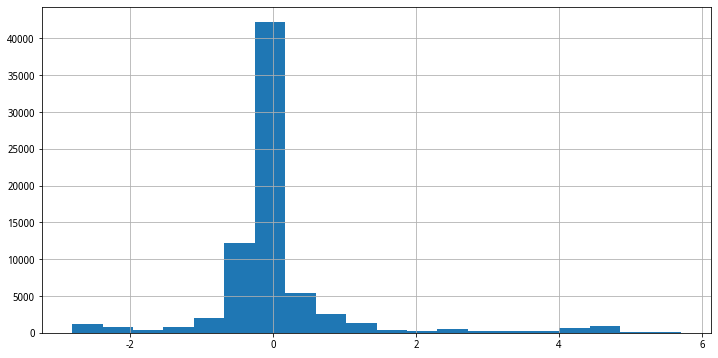

In [39]:
# 去极值化、标准化
factor_CFO_sr = factor_CFO_sr.groupby(level='date').apply(winsorize_series)
factor_CFO_sr = factor_CFO_sr.groupby(level='date').apply(standardize_series)

factor_CFO_df['cash_flow_from_operating_activities'] = factor_CFO_sr
factor_CFO_sr.hist(figsize=(12, 6), bins=20)

### 使用alphalens进行分析

In [40]:
factor_CFO_analysis = utils.get_clean_factor_and_forward_returns(
    factor_CFO_sr, price)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [41]:
factor_CFO_analysis['factor'] = np.float128(factor_CFO_analysis)
factor_CFO_analysis

1D        5D       10D    factor  \
date       asset                                                 
2019-01-02 000001.XSHE  0.009790  0.081610  0.140362  0.009790   
           000002.XSHE  0.007115  0.059832  0.063601  0.007115   
           000063.XSHE -0.039877  0.018405  0.038344 -0.039877   
           000069.XSHE  0.001678  0.045231  0.033499  0.001678   
           000100.XSHE  0.007982  0.123527  0.067739  0.007982   
           000157.XSHE  0.014401  0.048995  0.054755  0.014401   
           000166.XSHE  0.022286  0.089120  0.084167  0.022286   
           000333.XSHE -0.006586  0.070251  0.130624 -0.006586   
           000338.XSHE -0.009262  0.026443  0.074069 -0.009262   
           000413.XSHE  0.004492  0.082781  0.089496  0.004492   
           000415.XSHE  0.008499  0.067989  0.082153  0.008499   
           000423.XSHE -0.012643  0.026296  0.025537 -0.012643   
           000425.XSHE -0.006200  0.018664  0.018664 -0.006200   
           000538.XSHE -0.026971  0.033087  0.070485 -0.026971   
           000568.XSHE -0.037122 -0.002777  0.038132 -0.037122   
           000596.XSHE -0.037122  0.021212  0.100757 -0.037122   
           000625.XSHE  0.012082  0.125379  0.126893  0.012082   
           000627.XSHE -0.008897  0.008915 -0.005335 -0.008897   
           000629.XSHE  0.040134  0.043478  0.113712  0.040134   
           000630.XSHE  0.005140  0.035931  0.035931  0.005140   
           000651.XSHE  0.003354  0.047765  0.098044  0.003354   
           000656.XSHE  0.011495 -0.027913 -0.021339  0.011495   
           000661.XSHE -0.012816  0.051323  0.087243 -0.012816   
           000671.XSHE  0.005838  0.042728  0.031071  0.005838   
           000703.XSHE -0.006084  0.099131  0.076524 -0.006084   
           000709.XSHE  0.003520  0.031608  0.066664  0.003520   
           000723.XSHE -0.003135  0.031348  0.300940 -0.003135   
           000725.XSHE  0.000000  0.042613  0.034872  0.000000   
           000728.XSHE  0.027101  0.106981  0.099846  0.027101   
           000768.XSHE  0.034718  0.058117  0.064908  0.034718   
...                          ...       ...       ...       ...   
2019-12-17 601838.XSHG -0.003378 -0.007883  0.021396 -0.003378   
           601857.XSHG -0.005128 -0.020513 -0.003419 -0.005128   
           601877.XSHG  0.001139 -0.015572  0.017850  0.001139   
           601878.XSHG  0.099589  0.097536  0.142710  0.099589   
           601881.XSHG  0.005263 -0.003509  0.018421  0.005263   
           601888.XSHG -0.005840  0.018689  0.039014 -0.005840   
           601898.XSHG -0.002045  0.000000  0.026585 -0.002045   
           601899.XSHG -0.005013  0.032581  0.150376 -0.005013   
           601901.XSHG  0.000000  0.113764  0.217697  0.000000   
           601919.XSHG -0.011605 -0.011605  0.019342 -0.011605   
           601933.XSHG -0.010417  0.031250 -0.018229 -0.010417   
           601939.XSHG  0.001383 -0.005533  0.000000  0.001383   
           601985.XSHG  0.000000 -0.013619 -0.027237  0.000000   
           601988.XSHG -0.002717 -0.002717  0.002717 -0.002717   
           601989.XSHG -0.005607 -0.024299 -0.020561 -0.005607   
           601992.XSHG -0.002967  0.017804  0.106825 -0.002967   
           601997.XSHG -0.007239 -0.019648 -0.011375 -0.007239   
           601998.XSHG  0.001608 -0.014469 -0.008039  0.001608   
           603019.XSHG -0.006029 -0.057276 -0.052343 -0.006029   
           603156.XSHG -0.001414  0.006365  0.026521 -0.001414   
           603160.XSHG -0.024903 -0.113013 -0.065924 -0.024903   
           603259.XSHG -0.032311 -0.058793 -0.058078 -0.032311   
           603260.XSHG -0.008742 -0.005380 -0.009079 -0.008742   
           603288.XSHG -0.009303 -0.013954  0.000093 -0.009303   
           603501.XSHG -0.015298 -0.000989 -0.054402 -0.015298   
           603799.XSHG -0.006534  0.098631  0.225576 -0.006534   
           603833.XSHG  0.058196  0.052481  0.114392  0.058196   
           603899.XSHG -0.006257 -0.032325  0.016475 -0.006257   
    

In [42]:
# 计算因子IC
CFO_IC = performance.factor_information_coefficient(factor_CFO_analysis)
CFO_IC

,1D,5D,10D
date,,,
2019-01-02,1.0,0.545160,0.296790
2019-01-03,1.0,0.437517,0.376677
2019-01-04,1.0,0.617392,0.324937
2019-01-07,1.0,0.318565,0.211570
2019-01-08,1.0,0.520815,0.510667
2019-01-09,1.0,0.468214,0.402070
2019-01-10,1.0,0.371480,0.193102
2019-01-11,1.0,0.211748,0.093402
2019-01-14,1.0,0.459769,0.374113


In [43]:
CFO_IC_mean, CFO_IC_std, CFO_IR = mean_std_ir(CFO_IC['1D'])
print(CFO_IC_mean, CFO_IC_std, CFO_IR)

1.0 6.900070435564634e-17 1.4492605681903736e+16


In [44]:
# 计算IC>0.02的频率
CFO_freq = CFO_IC[CFO_IC['1D'] > 0.02]['1D'].count() / CFO_IC['1D'].count()
CFO_freq

1.0

In [45]:
# 计算因子收益率
factor_CFO_mean_return = performance.factor_returns(
    factor_CFO_analysis)['1D'].mean()
factor_CFO_mean_return

0.026977642598970387

## 将数值填写到表格以评分

In [46]:
result = pd.DataFrame({
    '指标': ['IC mean', 'IC std', 'IC>0.02', 'IR', '因子收益率', '因子总得分'],
    '标准': [0.01, 0.1, 0.4, 0.01, 0.01, '/'],
    'PE': [PE_IC_mean, PE_IC_std, PE_freq, PE_IR, factor_PE_mean_return, 0],
    'MC': [MC_IC_mean, MC_IC_std, MC_freq, MC_IR, factor_MC_mean_return, 0],
    'EPS': [
        EPS_IC_mean, EPS_IC_std, EPS_freq, EPS_IR, factor_EPS_mean_return, 0
    ],
    'CFO': [
        CFO_IC_mean, CFO_IC_std, CFO_freq, CFO_IR, factor_EPS_mean_return, 0
    ]
})

In [47]:
result

,指标,标准,PE,MC,EPS,CFO
0,IC mean,0.01,-0.002499,1.000000e+00,0.016371,1.000000e+00
1,IC std,0.1,0.169785,6.900070e-17,0.177179,6.900070e-17
2,IC>0.02,0.4,0.470085,1.000000e+00,0.474359,1.000000e+00
3,IR,0.01,-0.014721,1.449261e+16,0.092396,1.449261e+16
4,因子收益率,0.01,0.000395,2.697764e-02,0.000173,1.734933e-04
5,因子总得分,/,0.000000,0.000000e+00,0.000000,0.000000e+00


## 个人分析
在2019年全年每个交易日的时间来计算：
1. 市值与经营活动产生的现金流量净额在1天因子收益计算中，IC均值和IC>0.02频率为1，其余值特别小，人个觉得这两个指标在一天的变化很小，所以会产生异常值的情况。如果以5天、10天为标准结果会有不同，因此即使单因子模型分析中，选择计算周期也是值得研究的方向。
2. 市盈率中IC mean, IC>0.0, IR三者符合标准，基本每股收益中IC mean, IC>0.02, IR三者符合标准，其中EPS的IC mean, IR的绝对值比PE的大，所有在第二步选择EPS作为选股的单因子，并与上证指数做对比。

In [48]:
result.iloc[5, 2] = 3
result.iloc[5, 4] = 3

In [49]:
# 单因子模型评分表
result

,指标,标准,PE,MC,EPS,CFO
0,IC mean,0.01,-0.002499,1.000000e+00,0.016371,1.000000e+00
1,IC std,0.1,0.169785,6.900070e-17,0.177179,6.900070e-17
2,IC>0.02,0.4,0.470085,1.000000e+00,0.474359,1.000000e+00
3,IR,0.01,-0.014721,1.449261e+16,0.092396,1.449261e+16
4,因子收益率,0.01,0.000395,2.697764e-02,0.000173,1.734933e-04
5,因子总得分,/,3.000000,0.000000e+00,3.000000,0.000000e+00


## 根据EPS，选择沪深300的前20%的股票，计算每天的收益率，并与上证指数的作比较

In [50]:
# 筛选EPS前60名的股票
q = query(fundamentals.income_statement.basic_earnings_per_share).filter(
    fundamentals.income_statement.stockcode.in_(stockList)).order_by(
        fundamentals.income_statement.basic_earnings_per_share.desc()).limit(60)
upper60 = get_fundamentals(q, '20190101', expect_df=True).index

In [51]:
stockSH = index_components('000001.XSHG')

In [52]:
price_upper60 = get_price(upper60.levels[0],
                          '20190101',
                          '20191231',
                          fields='close')
price_upper60

,600009.XSHG,600332.XSHG,600436.XSHG,603259.XSHG,002032.XSHE,601997.XSHG,601318.XSHG,600585.XSHG,002916.XSHE,600309.XSHG,...,002466.XSHE,000002.XSHE,002739.XSHE,600519.XSHG,603799.XSHG,600741.XSHG,601828.XSHG,000661.XSHE,603156.XSHG,600566.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,49.9889,33.9168,83.9501,51.0586,51.1309,7.3164,53.9372,27.6251,64.8308,27.0230,...,24.2468,22.9793,21.92,590.2397,22.4734,17.4021,10.5401,169.6465,28.1663,27.5011
2019-01-03,49.3141,32.9964,80.5678,50.8315,47.2393,7.3441,54.4259,27.0595,62.1989,26.1773,...,24.3805,23.1428,21.55,581.3908,22.5271,16.4963,10.2856,167.4723,28.1933,26.3529
2019-01-04,49.4332,33.8871,82.2490,51.5199,49.2048,7.5379,55.3154,27.2225,63.3162,27.0325,...,25.2160,23.9697,21.78,593.2157,23.1633,16.6584,10.4716,172.0401,28.4296,27.9294
2019-01-07,49.3935,33.7584,82.9553,51.2502,50.1678,7.5310,55.0320,27.8168,65.7661,27.3175,...,25.5836,24.0850,22.37,596.6547,23.4239,16.9349,10.5890,175.0121,28.6455,28.2939
2019-01-08,49.4531,33.6496,83.0647,50.7747,50.1187,7.4756,54.5432,27.8455,70.2272,27.3555,...,25.2578,24.0370,22.06,595.9650,23.0943,17.0493,10.5498,175.0321,28.4836,28.6493
2019-01-09,50.2965,34.3622,84.7559,51.2076,50.9147,7.5033,55.6673,27.9797,70.6824,29.2274,...,24.5977,24.3542,21.99,607.1296,22.4734,17.9552,10.6183,178.3532,28.6185,29.1231
2019-01-10,49.4134,34.4413,84.1590,51.3425,49.5684,7.4549,56.2049,28.1139,70.7817,29.0278,...,24.3972,24.1427,21.38,609.7410,22.4658,17.8884,10.4520,176.6278,28.4093,28.8042
2019-01-11,48.7188,34.5898,84.7061,51.3709,49.2048,7.4826,56.7621,28.4398,70.5086,29.3699,...,24.4056,24.3254,21.35,626.6013,22.6344,17.8884,10.6379,177.5553,28.5645,29.1049
2019-01-14,47.5083,33.8970,84.1590,50.7818,49.8534,7.4549,55.8335,28.4398,70.5748,29.5789,...,24.3972,24.0562,21.49,615.4859,22.7034,17.6691,10.5205,169.4570,28.1191,28.5490


In [53]:
price_SH = get_price(stockSH, '2019-01-01', '2019-12-31', fields='close')

/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900921.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900933.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900908.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900928.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: invalid order_book_id: 900926.XSHG
  warnings.warn("invalid order_book_id: {}".format(ob), stacklevel=0)
/usr/local/lib/python3.6/site-packages/rqdatac/validators.py:147: UserWarning: i

In [54]:
price_SH

,600380.XSHG,601616.XSHG,600807.XSHG,600309.XSHG,603685.XSHG,600882.XSHG,600234.XSHG,600657.XSHG,600830.XSHG,603108.XSHG,...,600461.XSHG,600681.XSHG,603298.XSHG,600515.XSHG,601226.XSHG,600422.XSHG,603069.XSHG,600227.XSHG,600777.XSHG,600128.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.4087,3.1236,3.91,27.0230,10.8580,7.65,7.89,3.7012,4.7934,6.9982,...,5.2351,8.0695,11.6756,4.75,3.7172,5.9680,6.5901,2.83,1.87,8.06
2019-01-03,6.2422,3.1335,3.87,26.1773,10.7215,7.64,7.66,3.8372,4.8924,6.8892,...,5.2642,8.1246,11.7440,4.75,3.7372,5.9779,6.5208,2.85,1.89,8.17
2019-01-04,6.4577,3.3410,3.87,27.0325,11.0021,7.64,7.70,3.8954,5.1895,7.0379,...,5.3616,8.1315,11.9689,4.86,3.8368,6.1164,6.6991,2.94,1.91,8.45
2019-01-07,6.5361,3.6771,3.88,27.3175,11.1764,7.62,7.93,3.9537,5.2391,7.1073,...,5.4297,8.0695,12.0569,4.92,3.9265,6.2055,6.7784,2.96,2.10,8.54
2019-01-08,6.6243,4.0429,3.69,27.3555,11.2144,7.60,7.94,4.0314,5.2589,7.2758,...,5.4199,8.3865,11.9787,4.92,3.9365,6.1956,6.7190,2.96,2.03,8.59
2019-01-09,6.6341,4.4481,3.51,29.2274,11.1082,7.64,8.00,4.0120,5.2093,7.1172,...,5.4491,8.2694,11.9005,4.93,3.9564,6.2253,6.7487,2.97,2.08,8.76
2019-01-10,6.5851,4.6063,3.69,29.0278,11.2295,7.60,7.68,4.0509,5.1697,7.0775,...,5.4005,8.2625,11.8907,4.91,3.9465,6.1758,6.6694,2.96,2.07,8.31
2019-01-11,6.6145,4.1417,3.69,29.3699,11.3129,7.54,7.73,4.1189,5.2292,7.0478,...,5.4297,8.1660,12.0471,4.96,3.9863,6.2748,6.7289,3.01,2.09,8.22
2019-01-14,6.5557,3.9934,3.70,29.5789,11.1006,7.58,7.84,4.1674,4.7637,7.0379,...,5.4005,8.1315,12.0178,4.96,4.0362,6.1956,6.7487,3.01,2.10,8.41


In [55]:
price_upper60.isna().sum().sum()

0

In [56]:
price_SH.isna().sum().sum()

9182

In [57]:
# 处理上证指数成分股票缺失值
effective_SH = pd.DataFrame(price_SH.isna().sum())
effective_SH.columns = ['NA_count']
effective_SH_list = effective_SH[effective_SH['NA_count'] == 0].index
price_effective_SH = price_SH[effective_SH_list]
price_effective_SH

,600380.XSHG,601616.XSHG,600807.XSHG,600309.XSHG,603685.XSHG,600882.XSHG,600234.XSHG,600657.XSHG,600830.XSHG,603108.XSHG,...,600461.XSHG,600681.XSHG,603298.XSHG,600515.XSHG,601226.XSHG,600422.XSHG,603069.XSHG,600227.XSHG,600777.XSHG,600128.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.4087,3.1236,3.91,27.0230,10.8580,7.65,7.89,3.7012,4.7934,6.9982,...,5.2351,8.0695,11.6756,4.75,3.7172,5.9680,6.5901,2.83,1.87,8.06
2019-01-03,6.2422,3.1335,3.87,26.1773,10.7215,7.64,7.66,3.8372,4.8924,6.8892,...,5.2642,8.1246,11.7440,4.75,3.7372,5.9779,6.5208,2.85,1.89,8.17
2019-01-04,6.4577,3.3410,3.87,27.0325,11.0021,7.64,7.70,3.8954,5.1895,7.0379,...,5.3616,8.1315,11.9689,4.86,3.8368,6.1164,6.6991,2.94,1.91,8.45
2019-01-07,6.5361,3.6771,3.88,27.3175,11.1764,7.62,7.93,3.9537,5.2391,7.1073,...,5.4297,8.0695,12.0569,4.92,3.9265,6.2055,6.7784,2.96,2.10,8.54
2019-01-08,6.6243,4.0429,3.69,27.3555,11.2144,7.60,7.94,4.0314,5.2589,7.2758,...,5.4199,8.3865,11.9787,4.92,3.9365,6.1956,6.7190,2.96,2.03,8.59
2019-01-09,6.6341,4.4481,3.51,29.2274,11.1082,7.64,8.00,4.0120,5.2093,7.1172,...,5.4491,8.2694,11.9005,4.93,3.9564,6.2253,6.7487,2.97,2.08,8.76
2019-01-10,6.5851,4.6063,3.69,29.0278,11.2295,7.60,7.68,4.0509,5.1697,7.0775,...,5.4005,8.2625,11.8907,4.91,3.9465,6.1758,6.6694,2.96,2.07,8.31
2019-01-11,6.6145,4.1417,3.69,29.3699,11.3129,7.54,7.73,4.1189,5.2292,7.0478,...,5.4297,8.1660,12.0471,4.96,3.9863,6.2748,6.7289,3.01,2.09,8.22
2019-01-14,6.5557,3.9934,3.70,29.5789,11.1006,7.58,7.84,4.1674,4.7637,7.0379,...,5.4005,8.1315,12.0178,4.96,4.0362,6.1956,6.7487,3.01,2.10,8.41


In [58]:
# 再次检查缺失值
price_effective_SH.isna().sum().sum()

0

## 计算两者收益率

In [59]:
# 计算所有成人股的平均收盘价
price_upper60['mean'] = price_upper60.mean(axis=1)
price_upper60['mean']

date
2019-01-02    43.647347
2019-01-03    42.831570
2019-01-04    43.737145
2019-01-07    44.104640
2019-01-08    44.091625
2019-01-09    44.807122
2019-01-10    44.688660
2019-01-11    45.148313
2019-01-14    44.443718
2019-01-15    46.203980
2019-01-16    46.361968
2019-01-17    46.186763
2019-01-18    47.476613
2019-01-21    47.896175
2019-01-22    47.053735
2019-01-23    47.097438
2019-01-24    47.331598
2019-01-25    47.727725
2019-01-28    47.702940
2019-01-29    48.006667
2019-01-30    47.439652
2019-01-31    47.836918
2019-02-01    48.697737
2019-02-11    50.432707
2019-02-12    50.651557
2019-02-13    51.591615
2019-02-14    51.938427
2019-02-15    50.876612
2019-02-18    52.644578
2019-02-19    52.150348
                ...    
2019-11-20    75.376118
2019-11-21    74.825360
2019-11-22    72.950110
2019-11-25    72.740122
2019-11-26    73.292802
2019-11-27    73.157865
2019-11-28    72.930403
2019-11-29    71.190365
2019-12-02    71.230708
2019-12-03    71.043412
2019-12-04 

In [60]:
price_effective_SH['mean'] = price_effective_SH.mean(axis=1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
price_effective_SH['mean']

date
2019-01-02    10.698246
2019-01-03    10.600964
2019-01-04    10.839174
2019-01-07    11.015924
2019-01-08    10.980892
2019-01-09    11.040908
2019-01-10    11.016137
2019-01-11    11.123010
2019-01-14    11.027365
2019-01-15    11.188298
2019-01-16    11.205669
2019-01-17    11.110901
2019-01-18    11.222559
2019-01-21    11.291908
2019-01-22    11.191220
2019-01-23    11.206660
2019-01-24    11.251448
2019-01-25    11.205773
2019-01-28    11.148129
2019-01-29    10.992900
2019-01-30    10.856768
2019-01-31    10.726271
2019-02-01    10.980277
2019-02-11    11.261663
2019-02-12    11.381589
2019-02-13    11.575708
2019-02-14    11.630354
2019-02-15    11.552986
2019-02-18    11.917139
2019-02-19    11.906371
                ...    
2019-11-20    13.683706
2019-11-21    13.646578
2019-11-22    13.477410
2019-11-25    13.400512
2019-11-26    13.418727
2019-11-27    13.410758
2019-11-28    13.364709
2019-11-29    13.293250
2019-12-02    13.311502
2019-12-03    13.373534
2019-12-04 

In [62]:
# 计算成分股的每日收益率
price_upper60['daily return'] = np.diff(
    price_upper60['mean']) / price_upper60['mean'][:-1]
price_effective_SH['daily return'] = np.diff(
    price_effective_SH['mean']) / price_effective_SH['mean'][:-1]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
# 创建DF储存每日收益率和累计收益率数据
return_df = pd.DataFrame()
return_df['upper60 daily'] = price_upper60['daily return'][:-1]
return_df['shanghai daily'] = price_effective_SH['daily return'][:-1]

In [64]:
# 计算EPS前20%股票的累计收益率
cum_return = []
last_cum = 0
for index, row in price_upper60.iterrows():
    tmp = row['daily return'] + last_cum
    cum_return.append(tmp)
    last_cum = tmp

return_df['upper60 cumulative returns'] = cum_return[0:-1]
return_df['upper60 cumulative returns']

date
2019-01-02   -0.018690
2019-01-03    0.002453
2019-01-04    0.010855
2019-01-07    0.010560
2019-01-08    0.026787
2019-01-09    0.024143
2019-01-10    0.034429
2019-01-11    0.018823
2019-01-14    0.058429
2019-01-15    0.061849
2019-01-16    0.058070
2019-01-17    0.085997
2019-01-18    0.094834
2019-01-21    0.077245
2019-01-22    0.078174
2019-01-23    0.083146
2019-01-24    0.091515
2019-01-25    0.090995
2019-01-28    0.097362
2019-01-29    0.085551
2019-01-30    0.093925
2019-01-31    0.111920
2019-02-01    0.147548
2019-02-11    0.151887
2019-02-12    0.170446
2019-02-13    0.177169
2019-02-14    0.156725
2019-02-15    0.191475
2019-02-18    0.182087
2019-02-19    0.178479
                ...   
2019-11-19    0.570456
2019-11-20    0.563149
2019-11-21    0.538088
2019-11-22    0.535209
2019-11-25    0.542807
2019-11-26    0.540966
2019-11-27    0.537857
2019-11-28    0.513998
2019-11-29    0.514565
2019-12-02    0.511935
2019-12-03    0.517338
2019-12-04    0.526881
2019-1

In [65]:
# 计算上证指数股票的累计收益率
cum_return = []
last_cum = 0
for index, row in price_effective_SH.iterrows():
    tmp = row['daily return'] + last_cum
    cum_return.append(tmp)
    last_cum = tmp

return_df['shanghai cumulative returns'] = cum_return[0:-1]
return_df['shanghai cumulative returns']

date
2019-01-02   -0.009093
2019-01-03    0.013377
2019-01-04    0.029684
2019-01-07    0.026504
2019-01-08    0.031969
2019-01-09    0.029726
2019-01-10    0.039427
2019-01-11    0.030828
2019-01-14    0.045422
2019-01-15    0.046975
2019-01-16    0.038518
2019-01-17    0.048567
2019-01-18    0.054747
2019-01-21    0.045830
2019-01-22    0.047209
2019-01-23    0.051206
2019-01-24    0.047146
2019-01-25    0.042002
2019-01-28    0.028078
2019-01-29    0.015695
2019-01-30    0.003675
2019-01-31    0.027355
2019-02-01    0.052982
2019-02-11    0.063631
2019-02-12    0.080686
2019-02-13    0.085407
2019-02-14    0.078755
2019-02-15    0.110275
2019-02-18    0.109372
2019-02-19    0.109469
                ...   
2019-11-19    0.267398
2019-11-20    0.264685
2019-11-21    0.252289
2019-11-22    0.246583
2019-11-25    0.247942
2019-11-26    0.247348
2019-11-27    0.243915
2019-11-28    0.238568
2019-11-29    0.239941
2019-12-02    0.244601
2019-12-03    0.246069
2019-12-04    0.255782
2019-1

In [66]:
return_df

,upper60 daily,shanghai daily,upper60 cumulative returns,shanghai cumulative returns
date,,,,
2019-01-02,-0.018690,-0.009093,-0.018690,-0.009093
2019-01-03,0.021143,0.022471,0.002453,0.013377
2019-01-04,0.008402,0.016307,0.010855,0.029684
2019-01-07,-0.000295,-0.003180,0.010560,0.026504
2019-01-08,0.016227,0.005465,0.026787,0.031969
2019-01-09,-0.002644,-0.002244,0.024143,0.029726
2019-01-10,0.010286,0.009702,0.034429,0.039427
2019-01-11,-0.015606,-0.008599,0.018823,0.030828
2019-01-14,0.039607,0.014594,0.058429,0.045422


## 数据可视化

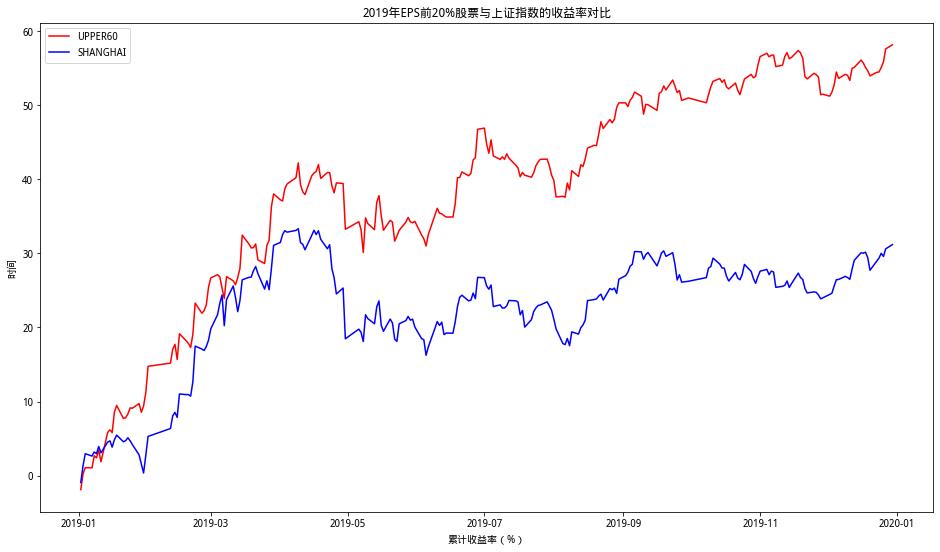

In [67]:
plt.figure(figsize=(16, 9))
plt.title('2019年EPS前20%股票与上证指数的收益率对比')
plt.ylabel('累计收益率（%）')
plt.xlabel('时间')
plt.plot(return_df['upper60 cumulative returns'] * 100,
         color='red',
         label='UPPER60')
plt.plot(return_df['shanghai cumulative returns'] * 100,
         color='blue',
         label='SHANGHAI')
plt.legend()
plt.show()

In [68]:
# 增加辅助线数据
return_df['zero'] = 0

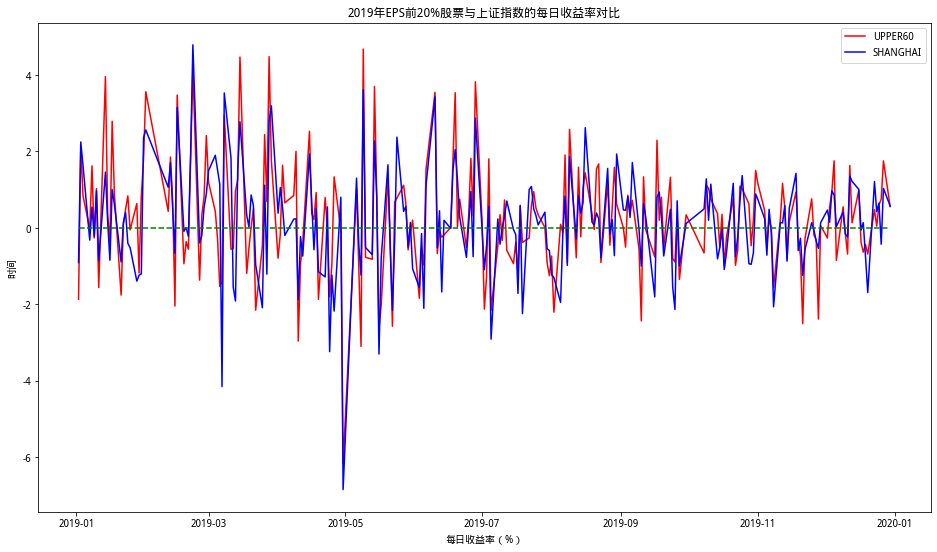

In [69]:
plt.figure(figsize=(16, 9))
plt.title('2019年EPS前20%股票与上证指数的每日收益率对比')
plt.ylabel('每日收益率（%）')
plt.xlabel('时间')
plt.plot(return_df['upper60 daily'] * 100, color='red', label='UPPER60')
plt.plot(return_df['shanghai daily'] * 100, color='blue', label='SHANGHAI')
plt.plot(return_df['zero'], color='green', linestyle='--')
plt.legend()
plt.show()

## 个人分析

In [70]:
# 在2019年中，用EPS因子选择沪深300前20%中60只股票与上证指数的收益率做对比，
# 在5月前，两者的收益率差距才拉开距离，到9月、10月左右距离更大，
# 因此使用EPS选择优质的沪深300股票与上证指数的基准收益对比，是成功的。

In [ ]:
# TODO 四个因子的数据可以获取后放在同一个表
# TODO 图表更新